In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta

In [35]:
def create_lstm_model(input_shape, lstm_units=50, dense_units=50):
    input_layer = Input(shape=input_shape, name="input_layer")
    lstm_layer = LSTM(lstm_units, return_sequences=False)(input_layer)
    dense_layer = Dense(dense_units, activation="relu")(lstm_layer)
    output_layer = Dense(1, activation="linear")(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="mean_squared_error")

    return model


def train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, lstm_units=50, dense_units=50, epochs=50, batch_size=32):
    input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input for LSTM
    model = create_lstm_model(input_shape, lstm_units, dense_units)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    # Evaluate model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    # Predict sales
    predicted_sales = model.predict(X_test)

    return model, history, train_loss, test_loss, predicted_sales

In [24]:
# Load and Prepare Data
df = pd.read_csv("selected_sales.csv")

# Convert ticket_end_time to datetime and set as index
df["ticket_end_time"] = pd.to_datetime(df["ticket_end_time"])
df.set_index("ticket_end_time", inplace=True)

# Create time-based features
df["day_of_week"] = df.index.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["month"] = df.index.month
df["day_of_month"] = df.index.day
df["week_of_year"] = df.index.isocalendar().week

# Calculate rolling averages
df["sales_qty_7day_avg"] = df.groupby("article_code")["sales_qty_base_uom"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df["sales_qty_30day_avg"] = df.groupby("article_code")["sales_qty_base_uom"].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Create lag features
df["sales_qty_lag1"] = df.groupby("article_code")["sales_qty_base_uom"].shift(1)
df["sales_qty_lag7"] = df.groupby("article_code")["sales_qty_base_uom"].shift(7)

# Create a price category based on the average price of the article
df["avg_price"] = df.groupby("article_code")["sales_qty_base_uom"].transform("mean")

# Drop rows with missing values created by shifting
df.dropna(inplace=True)

In [18]:
df.head()

,date_key,unique_ticket_id,article_code,sales_qty_alternate_uom,alternate_uom,sales_qty_base_uom,base_uom_x,article_desc,base_uom_y,super_dept_no,...,day_of_week,is_weekend,month,day_of_month,week_of_year,sales_qty_7day_avg,sales_qty_30day_avg,sales_qty_lag1,sales_qty_lag7,avg_price
ticket_end_time,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:52:03,20220103,7bdbd0d5-6d77-46f3-8adb-e4e7a2c6c5c3,10602621,2.0,EA,2.0,EA,"ENERGY DRINK SCORE 500ML, ORIG",EA,10,...,0.0,0,1.0,3.0,1,1.285714,1.250000,1.0,1.0,1.253158
2022-01-03 10:11:18,20220103,ed8b1815-8d7d-4156-98bf-299ef74e3493,10602621,1.0,EA,1.0,EA,"ENERGY DRINK SCORE 500ML, ORIG",EA,10,...,0.0,0,1.0,3.0,1,1.285714,1.222222,2.0,1.0,1.253158
2022-01-03 10:29:09,20220103,326120d1-ce55-42de-abab-7b640f91dfb3,10131982,2.0,EA,2.0,EA,SUGAR WHITE RITEBRAND 2KG PACK,EA,10,...,0.0,0,1.0,3.0,1,1.285714,2.375000,1.0,10.0,1.134101
2022-01-03 10:40:38,20220103,aff20993-fbb5-419d-94b5-40a534e4b714,10604301,1.0,EA,1.0,EA,"SOFT DRNK COCA COLA 440ML, ORIG",EA,10,...,0.0,0,1.0,3.0,1,1.000000,1.000000,1.0,1.0,1.142238
2022-01-03 10:42:41,20220103,7d0af17c-500e-47bb-856b-62133e51e1a5,10131982,1.0,EA,1.0,EA,SUGAR WHITE RITEBRAND 2KG PACK,EA,10,...,0.0,0,1.0,3.0,1,1.285714,2.222222,2.0,1.0,1.134101


In [47]:
# Define feature columns and target
feature_columns = ["day_of_week", "is_weekend", "month", "day_of_month", "week_of_year", "sales_qty_7day_avg", "sales_qty_30day_avg", "sales_qty_lag1", "sales_qty_lag7"]
target_column = "sales_qty_base_uom"

# Check for NaN values in the data using pandas isna()
assert not df[feature_columns].isna().any().any(), "Input data contains NaN values"
assert not df[target_column].isna().any(), "Target data contains NaN values"

# Ensure all data is of float type
df[feature_columns] = df[feature_columns].astype(np.float32)
df[target_column] = df[target_column].astype(np.float32)

# Define the best article code
article_code = 10248591

# Filter the data for the selected article code
product_data = df[df["article_code"] == article_code]

# Ensure the data is sorted by date and resample to fill missing dates
product_data = product_data.resample("D").sum()
product_data["sales_qty_base_uom"].fillna(0, inplace=True)

# Prepare input data for LSTM
X = product_data[feature_columns].values.astype(np.float32)
y = product_data[target_column].values.astype(np.float32)

# Reshape input data for LSTM (samples, timesteps, features)
timesteps = 1  # Single timestep for each sample
X = X.reshape((X.shape[0], timesteps, X.shape[1]))

# Split data into training and testing sets
split_ratio = 0.7
train_size = int(len(X) * split_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
input_layer = Input(shape=(timesteps, X.shape[2]), name="input_layer")
lstm_layer = LSTM(25, return_sequences=False)(input_layer)
dense_layer = Dense(75, activation="relu")(lstm_layer)
output_layer = Dense(1, activation="linear")(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/300


/var/folders/2n/nk_kz9ln5yn5w2l0d_6mznh40000gn/T/ipykernel_45370/842175754.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  product_data["sales_qty_base_uom"].fillna(0, inplace=True)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 37964.6172 - val_loss: 7283.8682
Epoch 2/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46027.1875 - val_loss: 7196.8403
Epoch 3/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42527.8672 - val_loss: 7091.5513
Epoch 4/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53405.7656 - val_loss: 6962.1284
Epoch 5/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47764.8945 - val_loss: 6775.3838
Epoch 6/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42479.4883 - val_loss: 6546.5132
Epoch 7/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48683.4062 - val_loss: 6279.3442
Epoch 8/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43081.7031 - val_loss: 5975.0879
Epoch 9/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50410.9062 - val_loss: 5632.5811
Epoch 10/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51660.3281 - val_loss: 5298.2036
Epoch 11/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46225.2500 - val_loss: 5001.821

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


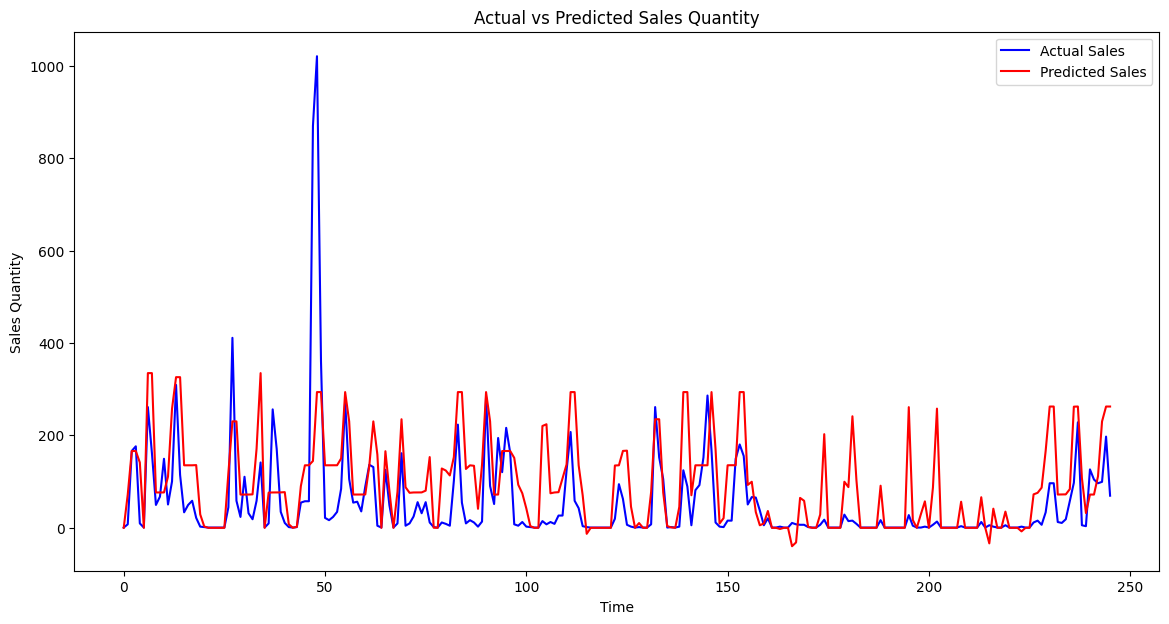

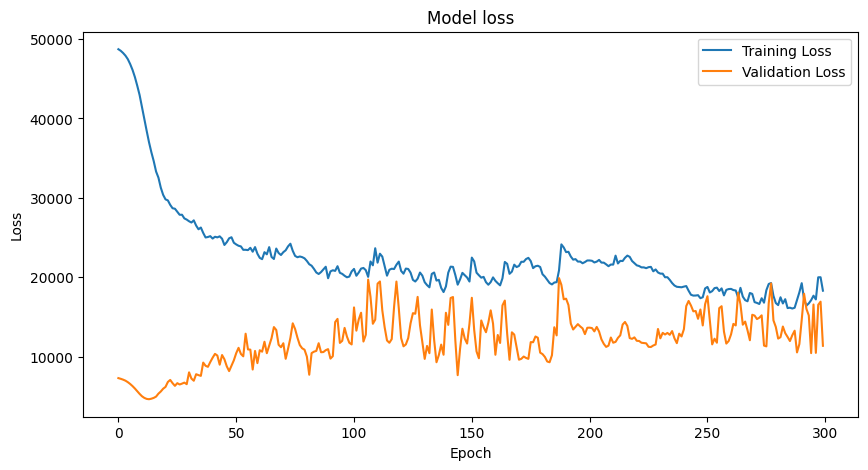

In [48]:
# Predict sales for the test set (last 30% of the data)
predicted_sales = model.predict(X_test)

# Plot actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(y_test, label="Actual Sales", color="blue")
plt.plot(predicted_sales, label="Predicted Sales", color="red")
plt.title("Actual vs Predicted Sales Quantity")
plt.xlabel("Time")
plt.ylabel("Sales Quantity")
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


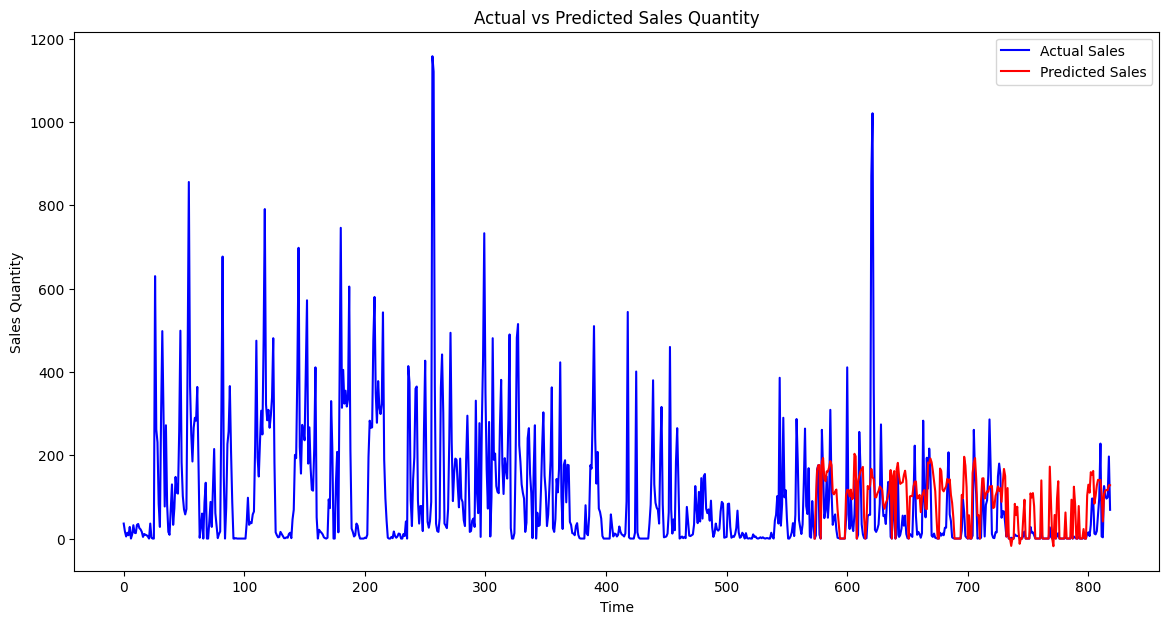

In [34]:
# Predict sales for the entire time series (X)
predicted_sales = model.predict(X)

# Plot actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(y, label="Actual Sales", color="blue")
plt.plot(np.arange(train_size, len(y)), predicted_sales[train_size:], label="Predicted Sales", color="red")
plt.title("Actual vs Predicted Sales Quantity")
plt.xlabel("Time")
plt.ylabel("Sales Quantity")
plt.legend()
plt.show()

Training LSTM with units: 25, dense units: 25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Loss for LSTM (25, 25): 11321.314453125
Training LSTM with units: 75, dense units: 25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Loss for LSTM (75, 25): 12970.0830078125
Training LSTM with units: 25, dense units: 75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test Loss for LSTM (25, 75): 13487.8369140625
Training LSTM with units: 75, dense units: 75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Loss for LSTM (75, 75): 9944.2548828125
Training LSTM with units: 50, dense units: 50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Loss for LSTM (50, 50): 11454.0498046875
Training LSTM with units: 100, dense units: 50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test Loss for LSTM (100, 50): 12457.7822265625
Training LSTM with units: 50, dense units: 100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test Loss for LSTM (50, 100): 13013.4501953125
Training LSTM with units: 100, dense units: 100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Los

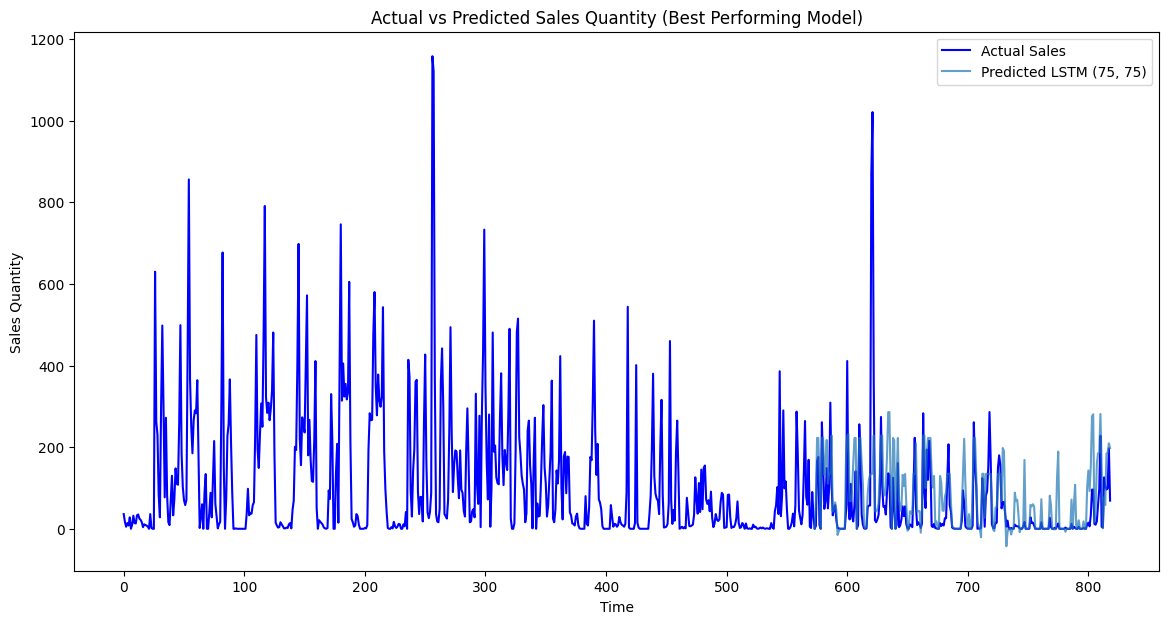

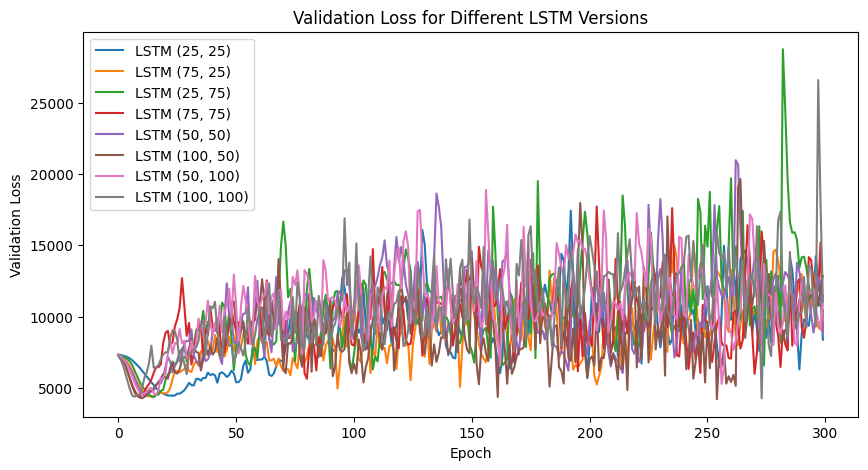

In [49]:
# Define different versions of LSTM parameters to test
lstm_versions = [
    {"lstm_units": 25, "dense_units": 25, "epochs": 300, "batch_size": 32},
    {"lstm_units": 75, "dense_units": 25, "epochs": 300, "batch_size": 32},
    {"lstm_units": 25, "dense_units": 75, "epochs": 300, "batch_size": 32},
    {"lstm_units": 75, "dense_units": 75, "epochs": 300, "batch_size": 32},
    {"lstm_units": 50, "dense_units": 50, "epochs": 300, "batch_size": 32},
    {"lstm_units": 100, "dense_units": 50, "epochs": 300, "batch_size": 32},
    {"lstm_units": 50, "dense_units": 100, "epochs": 300, "batch_size": 32},
    {"lstm_units": 100, "dense_units": 100, "epochs": 300, "batch_size": 32},
]

# Train and evaluate each version of the LSTM model
results = []
for version in lstm_versions:
    print(f"Training LSTM with units: {version['lstm_units']}, dense units: {version['dense_units']}")
    model, history, train_loss, test_loss, predicted_sales = train_and_evaluate_lstm_model(
        X_train, y_train, X_test, y_test, lstm_units=version["lstm_units"], dense_units=version["dense_units"], epochs=version["epochs"], batch_size=version["batch_size"]
    )

    results.append(
        {
            "model": model,
            "history": history,
            "train_loss": train_loss,
            "test_loss": test_loss,
            "predicted_sales": predicted_sales,
            "lstm_units": version["lstm_units"],
            "dense_units": version["dense_units"],
        }
    )

    print(f"Test Loss for LSTM ({version['lstm_units']}, {version['dense_units']}): {test_loss}")

# Find the best performing model based on test loss
best_model_index = np.argmin([result["test_loss"] for result in results])
best_model = results[best_model_index]
best_lstm_units = best_model["lstm_units"]
best_dense_units = best_model["dense_units"]
best_test_loss = best_model["test_loss"]

print(f"\nBest Performing Model:")
print(f"LSTM Units: {best_lstm_units}, Dense Units: {best_dense_units}")
print(f"Test Loss: {best_test_loss}")

# Plot actual vs predicted sales for the best performing model
plt.figure(figsize=(14, 7))
plt.plot(y, label="Actual Sales", color="blue")
predicted_sales = best_model["model"].predict(X_test)
plt.plot(np.arange(train_size, train_size + len(y_test)), predicted_sales.flatten(), label=f"Predicted LSTM ({best_lstm_units}, {best_dense_units})", alpha=0.7)
plt.title("Actual vs Predicted Sales Quantity (Best Performing Model)")
plt.xlabel("Time")
plt.ylabel("Sales Quantity")
plt.legend()
plt.show()

# Plot training & validation loss values for each LSTM version
plt.figure(figsize=(10, 5))
for result in results:
    history = result["history"]
    lstm_units = result["lstm_units"]
    dense_units = result["dense_units"]
    plt.plot(history.history["val_loss"], label=f"LSTM ({lstm_units}, {dense_units})")

plt.title("Validation Loss for Different LSTM Versions")
plt.ylabel("Validation Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()